In [2]:
!git clone https://github.com/shoaib6174/MultiWOZ-Clustering/


!pip install kneed
!pip install yellowbrick
!pip install pyclustering

!mkdir uci_bow
!mkdir uci_bow/train
!mkdir uci_bow/test
!mkdir multiwoz_batches

!pip install bigartm10
!pip install kneed


Cloning into 'MultiWOZ-Clustering'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 105 (delta 54), reused 83 (delta 32), pack-reused 0
Receiving objects: 100% (105/105), 14.89 MiB | 6.34 MiB/s, done.
Resolving deltas: 100% (54/54), done.
     |████████████████████████████████| 2.6 MB 5.4 MB/s 
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395122 sha256=210602e226e51d90c3c901c75aa3c33458a6daae0718b4f6241f42fec37acc4e
  Stored in directory: /root/.cache/pip/wheels/ea/87/6b/1e0568b5ba9dc6518a25338bae90bd8392f35206bb90bb10f1
Successfully built pyclustering
     |████████████████████████████████| 2.0 MB 5.1 MB/s 


In [51]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import ast
import nltk
import string 
import artm

from pyclustering.utils import read_sample;
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

import tensorflow_hub as hub 
from scipy.spatial import distance
import tensorflow as tf

from sklearn.cluster import KMeans
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.cluster import KElbowVisualizer

from sklearn import metrics
from scipy.spatial.distance import cdist

from random import choices, sample

# Utterance Representation 

I represented the utterances using tf-idf format. 

Steps: 



1.   Extracted the uttereances from json file of dialogues in a list(**utterances**) using **extract_texts()** function
2.   Cleaned the text using tokenization, lowercasing, punctuation and stop word removal, stripping,  and kept them in a list(**cleaned_texts**) using clean()  
3. Then I embedded the utterances using "Universal Sentence Encoder"




# Functions

## Preprocessing functions

showing histogram of count of dialogues from services

In [4]:

import operator

def plot_services_from_dict(services_dict):
  services_count = {}
  
  for s in services_dict:
    services_count[s] = len(services_dict[s])

  sorted_services_count = sorted(services_count.items(), key=operator.itemgetter(1),  reverse=True)

  df_service_freq = pd.DataFrame(sorted_services_count, columns=['services', 'frequency'])


  df_service_freq.plot(kind='bar', x='services')

cleaning texts

In [5]:
nltk.download("stopwords")
nltk.download('punkt')

stop_words = set(nltk.corpus.stopwords.words('english'))
stemmer = nltk.stem.PorterStemmer()
def clean(text):
  """
  Description: Returns cleaned text
  Params: 
    text: text to be cleaned
  """
  tokens = nltk.tokenize.word_tokenize(text)
  tokens = [w.lower() for w in tokens]
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  words = [word for word in stripped if word.isalnum()]
  #words = [w for w in words if not w in stop_words]
  
  stemmed_words = words
  #stemmed_words = [stemmer.stem(word) for word in words]
  sentence = " ".join(stemmed_words)
  return sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Embeddings


In [71]:
def preprocess(cleaned_text, dir):
  tfidf = TfidfVectorizer()
  response = tfidf.fit_transform(cleaned_text)
  df = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())

  D = len(df.index)
  W = len(df.columns)
  C = np.count_nonzero(df)
  print(D, W, C)
  with open(f'uci_bow/{dir}/docword.multiwoz.txt', 'w') as docword:
    docword.write(f"{D}\n{W}\n{C}\n")
    for docID , row in df.iterrows():
      for wordID , val in enumerate(row):
        if val > 0:
          docword.write(f"{docID } {wordID+1 } {val}\n")


  with open(f'uci_bow/{dir}/vocab.multiwoz.txt', 'w') as vocab:
    for col in df.columns:
      vocab.write(f"{col}\n")



In [72]:
def get_embeddings():
  batch_vectorizer = artm.BatchVectorizer(data_path='/content/uci_bow/train', data_format='bow_uci',
                                          collection_name='multiwoz', target_folder='multiwoz_batches')
  batch_vectorizer_test = artm.BatchVectorizer(data_path='/content/uci_bow/test', data_format='bow_uci',
                                          collection_name='multiwoz', target_folder='multiwoz_batches')

  num_topics = 250
  num_collection_passes = 10
  scores= []
  cache_theta  = True

  model = artm.ARTM(num_topics=num_topics, dictionary=batch_vectorizer.dictionary, cache_theta = cache_theta ,
                    regularizers = [artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhiRegularizer')],
                    scores=[artm.TopTokensScore(name='top_tokens_score')])

  model.scores.add(artm.PerplexityScore(name='my_first_perplexity_score',
                                        dictionary=batch_vectorizer_test.dictionary))

  model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes= num_collection_passes)

  topic_df = model.get_theta().T

  return topic_df

In [116]:
def embed(train_df, test_df, preprocess,get_embeddings ):
  preprocess(list(train_df['cleaned_text']), "train")
  preprocess(list(test_df['cleaned_text']), "test")
  
  embeddings =  get_embeddings()

  return embeddings

In [ ]:
# def show_top_5_similar_embeddings(embeddings, cleaned_texts, test_utterances = ["what day were you looking to travel", "i want to leave on tuesday", "thank you", "what day were you planning to travel" ]):
#   """
#   Description: prints top 5 simmilar utterances
#   Params: 
#     test_utterances: utterances to find top 5 simillar utterance of
#     cleaned_texts: utterances
#     embeddings: embeddings of all utterances
#   """
  
#   test_embeddings = embed(test_utterances)

#   similarity_matrix = []
#   for idx in range(len(test_utterances)):
#     similarity = {}
#     for idx2 in range(len(embeddings)):
#       similarity[1 - distance.cosine(test_embeddings[idx], embeddings[idx2])] = idx2
#     similarity_matrix.append(similarity)


#   for i in range(len(test_utterances)):
#     scores = sorted(list(similarity_matrix[i].keys()))[-6:-1]
#     print('Utterance:', test_utterances[i])
#     print("Top 5: ")
#     for s in scores:
#       id = similarity_matrix[i][s]
#       print(s, cleaned_texts[id])
#     print()

## Clustering Functions

Histogram

In [78]:
def show_hist(clusters, title):
  """
  Description: Shows a histogram of count of items in each clusters, No oftotoal clusters and 
                total count of items in the clusters
  Params: 
    clusters: a list containing the lists of items of each clusters
    titile: Name of the algorithom
  """
  names = list(f"{i+1}" for i in range(len(clusters)) )
  values = list(len(c) for c in clusters)
  print(f"Total Cluster: {len(clusters)} \nTotal count of uttarance in Clusters:{sum(values)}")
  y_pos = np.arange(len(clusters))

  plt.figure(figsize=(20,10))
  plt.bar(y_pos, values, align='center', alpha=0.5)
  plt.xticks(y_pos, names)
  plt.ylabel('Count')
  plt.title(title)

  plt.show()

 Find Similar Clusters

In [79]:
def find_similar_clusters(centers, threshold = 0.7,  clusters_to_check = None):
  '''
    Description:  Finds similarity between clusters and prints clusters which has clusters whose similarity score passes the threshold.

    Params:
      centers: centers of the clusters
      threshold: threshold to check
      clusters_to_check: [List] Give cluster numbers in list if you want to check for specific clusters. If not passed, all the clusters will be checked.
  '''
  if clusters_to_check is None:
    clusters_to_check = list(range(len(centers)))

  similarity_matrix = []
  for i in range(len(centers)):
    similarity = {}
    for j in range(len(centers)):
      if i == j:
        continue
      similarity[1- distance.cosine(centers[i], centers[j])] = j
    similarity_matrix.append(similarity)

  for i in clusters_to_check:
    scores = list(similarity_matrix[i].keys())
    above_70 = list(filter(lambda score: score >= threshold, scores))
    if len(above_70) > 0:
      print(f"Clusters Similar with", i, ":")
      for s in above_70:
        id = similarity_matrix[i][s]
        print(id, s)
      print()

Print items from clusters

In [80]:
def print_cluster_items(clusters, cleaned_texts, num_of_items=5):
  for idx, cluster in enumerate(clusters):
    print(f"\n\nCluster No: {idx}\t Count: [{len(cluster)}]\n")
    
    if len(cluster) > num_of_items :
      for i in cluster[:num_of_items]:
        print(i, cleaned_texts[i])
    else:
      for i in cluster:
        print(i, cleaned_texts[i])

In [81]:
def save_nodes_with_n_utterances(speaker_prefix, n, clusters, cleaned_texts):
  nodes = {}
  for idx, cluster in enumerate(clusters):
      utterances = []
      if len(cluster) > n :
          for i in cluster[:n]:
            utterances.append(cleaned_texts[i])
      else:
          for i in cluster:
            utterances.append(cleaned_texts[i])      
      nodes[f"{speaker_prefix}-{idx}"] = utterances

  return nodes

Find Elbow Point

In [82]:
def findElbowPoint(embeddings, k, metric='distortion' ):
  '''
    metric: distortion/silhouette/calinski_harabasz
  '''
  model = KMeans()
  visualizer = KElbowVisualizer(model,k=k, metric=metric, timings=False)
  visualizer.fit(embeddings)        # Fit the data to the visualizer
  visualizer.show()  

Distortion

In [83]:
def distortion(embeddings, K):
  distortions = []
  inertias = []
  mapping1 = {}
  mapping2 = {}


  for k in K:
      # Building and fitting the model
      kmeanModel = KMeans(n_clusters=k).fit(embeddings)
      kmeanModel.fit(embeddings)
  
      distortions.append(sum(np.min(cdist(embeddings, kmeanModel.cluster_centers_,
                                          'euclidean'), axis=1)) / embeddings_user.shape[0])
      inertias.append(kmeanModel.inertia_)
  
      mapping1[k] = sum(np.min(cdist(embeddings, kmeanModel.cluster_centers_,
                                    'euclidean'), axis=1)) / embeddings.shape[0]
      mapping2[k] = kmeanModel.inertia_

  plt.plot(K, distortions, 'bx-')
  plt.xlabel('Values of K')
  plt.ylabel('Distortion')
  plt.title('The Elbow Method using Distortion')
  plt.show()

Clustering

In [84]:
def xmeans_clustering(embeddings, number_of_clusters= 300):
  amount_initial_centers = 5

  initial_centers = kmeans_plusplus_initializer(embeddings, amount_initial_centers).initialize()
  
  # Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
  # number of clusters that can be allocated is number_of_clusters.
  xmeans_instance = xmeans(embeddings, initial_centers, number_of_clusters)
  xmeans_instance.process()
  
  # Extract clustering results: clusters and their centers
  clusters = xmeans_instance.get_clusters()
  centers = xmeans_instance.get_centers()
  
  # Print total sum of metric errors
  print("Total WCE:", xmeans_instance.get_total_wce())
  
  #histogram
  show_hist(clusters, "xmeans")

  return clusters , centers



Clustering Clusters

In [85]:
def find_clusters(i, clusters_to_check, similarity_matrix, threshold):
  try:
      clusters_to_check.remove(i)
  except:
      pass



  i = int(i)
  scores = list(similarity_matrix[i].keys())
  above_70 = list(filter(lambda score: score >= threshold, scores))

  sim_clusters = [i]


  for cl in above_70:
    j = similarity_matrix[i][cl]

    sim_clusters.append(int(j))

    if j in clusters_to_check:
      result = find_clusters(j, clusters_to_check, similarity_matrix, threshold)

      sim_clusters += result 

  return set(sim_clusters)
  

In [86]:
def clustering_clusters(centers, clusters):

  similarity_matrix = []

  for i in range(len(centers)):
    similarity = {}
    for j in range(len(centers)):
      if i == j:
        continue
      similarity[1- distance.cosine(centers[i], centers[j])] = j
    similarity_matrix.append(similarity)


  clusters_to_check = list(range(len(centers)))

  threshold = .8

  clustered_clusters = []

  while clusters_to_check:
    item = clusters_to_check.pop(0)

    result= find_clusters(item,clusters_to_check, similarity_matrix, threshold)
    clustered_clusters.append(result)
  
  clustered_clusters_combined = []

  for  clustered_clusters in clustered_clusters:
    clusters_combined = []
    for cluster_no in clustered_clusters:
      clusters_combined += clusters[cluster_no]
    clustered_clusters_combined.append(clusters_combined)

  return clustered_clusters_combined



# Pre Processing

### Sampling

Getting ids of services in service_id dictionary

In [88]:
def get_all_service_id(path, file_list):
  services_id = {}

  for file in file_list:
    with open(f'{path}/{file}') as f:
      data = json.load(f)

      for item in data:
        dialogue_id = item["dialogue_id"]
        service = " & ".join(item["services"])
        if service in services_id:
          services_id[service].append(dialogue_id)
        else:
          services_id[service] = [dialogue_id]
  return services_id



In [91]:
path = "MultiWOZ-Clustering/train"
file_list = os.listdir(path) 

services_id_train = get_all_service_id(path, file_list)

path = "MultiWOZ-Clustering/test"
file_list = os.listdir(path) 

services_id_test = get_all_service_id(path, file_list)

showing histogram of count of dialogues from services

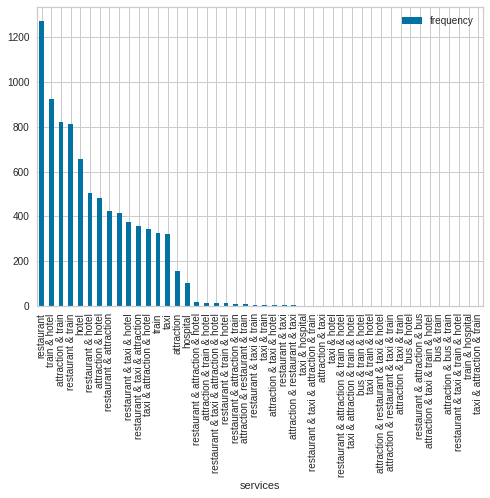

In [7]:
plot_services_from_dict(services_id_train)

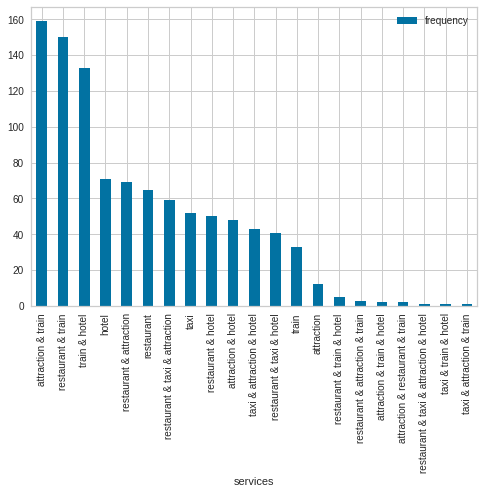

In [92]:
plot_services_from_dict(services_id_test)

empty service = 357

multi-service = 5525

2+ services = 1496

3+ services = 34

3 services = 1462

sample k items from each of the services in sampled_services_id dict

In [99]:

"""
  choices: sampling with replacement(repetition)
  sample: sampling without replacement(no repetition)
"""
def get_sampled_id(services_id, k, l):
  k = 200
  sampled_services_id = {}

  for service in services_id:
    if len(services_id[service]) > l:
      sampled_services_id[service] = choices(services_id[service], k=k)

  return sampled_services_id


In [100]:
sampled_services_id_test = get_sampled_id(services_id_test,40, 10)
sampled_services_id_train = get_sampled_id(services_id_train,40, 10)

 distribution of dialogues count after sampling


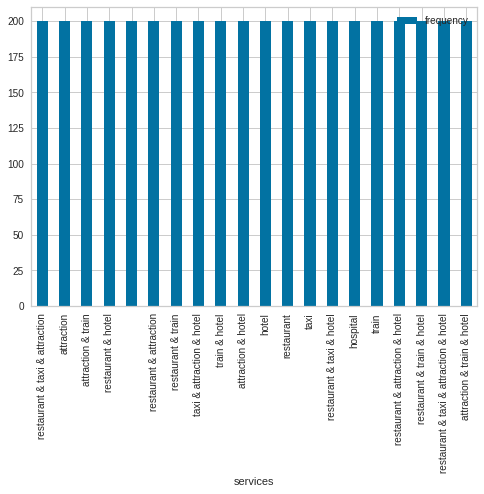

In [102]:
plot_services_from_dict(sampled_services_id_train)

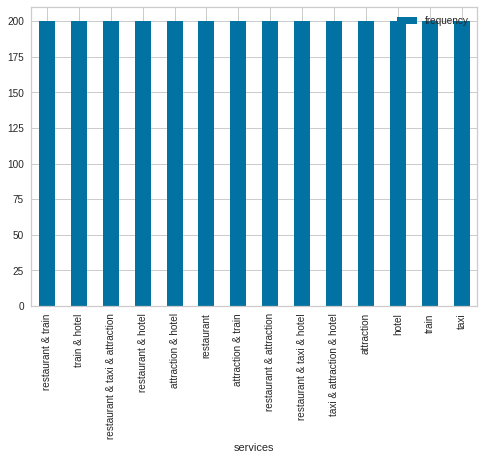

In [101]:
plot_services_from_dict(sampled_services_id_test)

dictionary of ids for easy acessability

In [106]:
def make_id_dict(sampled_services_id):

  dialogue_ids_dict = {}
  for service in sampled_services_id:
    for id in sampled_services_id[service]:
      dialogue_ids_dict[id] = service

  return dialogue_ids_dict

In [107]:
dialogue_ids_dict_test = make_id_dict(sampled_services_id_test)
dialogue_ids_dict_train = make_id_dict(sampled_services_id_train)

### Extracting texts from the sampled dialogues

In [108]:


def get_df(path, file_list, dialogue_ids_dict):
  dialogues = []

  for file in file_list:
    with open(f'{path}/{file}') as f:

      data = json.load(f)
      for item in data:
        dialogue_id = item["dialogue_id"]
        if dialogue_id in dialogue_ids_dict:
          utterance_count = len(item['turns'])
          for idx, turn in enumerate(item['turns']):
            next_utterance_id =  f'{idx+1}-{dialogue_id[:-5]}' if idx < utterance_count - 1 else ""

            dialogues.append({
                "dialogue_id" : dialogue_id[:-5],
                "services": dialogue_ids_dict[dialogue_id],
                "services_list" : item["services"],
                "utterance_no": idx, 

                "utterance_id" : f'{idx}-{dialogue_id[:-5]}', 
                "next_utterance_id": next_utterance_id,
                
                "speaker" : turn['speaker'],
                "text" : turn['utterance'],
                "cleaned_text" : clean(turn['utterance'])
                })

  df = pd.DataFrame(dialogues)
  return df

In [109]:
path = "MultiWOZ-Clustering/train"
file_list = os.listdir(path)

df_train = get_df(path, file_list, dialogue_ids_dict_train)

path = "MultiWOZ-Clustering/test"
file_list = os.listdir(path)

df_test = get_df(path, file_list, dialogue_ids_dict_test)

In [ ]:
# df.to_csv("dialogues_200_with_replacement.csv")

In [110]:
df_train = pd.read_csv("/content/MultiWOZ-Clustering/dialogues_200_with_replacement.csv")
df_train.fillna('', inplace=True)
df_train

,Unnamed: 0,dialogue_id,services,services_list,utterance_no,utterance_id,next_utterance_id,speaker,text,cleaned_text
0,0,SNG02022,hospital,['hospital'],0,0-SNG02022,1-SNG02022,USER,I am looking for the Addenbrookes Hospital wit...,i am looking for the addenbrookes hospital wit...
1,1,SNG02022,hospital,['hospital'],1,1-SNG02022,2-SNG02022,SYSTEM,The telephone number is 01223217712,the telephone number is 01223217712
2,2,SNG02022,hospital,['hospital'],2,2-SNG02022,3-SNG02022,USER,Thank you Goodbye,thank you goodbye
3,3,SNG02022,hospital,['hospital'],3,3-SNG02022,,SYSTEM,Have a wonderful day!,have a wonderful day
4,4,PMUL4452,restaurant & taxi & hotel,"['restaurant', 'taxi', 'hotel']",0,0-PMUL4452,1-PMUL4452,USER,I am traveling to Cambridge and looking forwar...,i am traveling to cambridge and looking forwar...
...,...,...,...,...,...,...,...,...,...,...
33319,33319,MUL2568,taxi & attraction & hotel,"['taxi', 'attraction', 'hotel']",15,15-MUL2568,16-MUL2568,SYSTEM,I have booked a car from the acorn to country ...,i have booked a car from the acorn to country ...
33320,33320,MUL2568,taxi & attraction & hotel,"['taxi', 'attraction', 'hotel']",16,16-MUL2568,17-MUL2568,USER,No that was it. Thanks for your help!,no that was it thanks for your help
33321,33321,MUL2568,taxi & attraction & hotel,"['taxi', 'attraction', 'hotel']",17,17-MUL2568,18-MUL2568,SYSTEM,So glad that I could assist. Please call again.,so glad that i could assist please call again
33322,33322,MUL2568,taxi & attraction & hotel,"['taxi', 'attraction', 'hotel']",18,18-MUL2568,19-MUL2568,USER,Ok. Good bye!,ok good bye


# Clustering

## USER utterances only

* here I extracted and clustered only the utterances of USER. 

In [125]:
cleaned_texts_user = list(df_train.loc[df_train['speaker'] == "USER", 'cleaned_text'])

In [117]:
embeddings_user =  embed(df_train[df_train["speaker"]=="USER"], df_test[df_test["speaker"]=="USER"], preprocess,get_embeddings )

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


16662 2489 164619


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


6137 1653 62000


In [113]:
# test_utterances = choices(cleaned_texts_user, k = 20)

# show_top_5_similar_embeddings(embeddings_user, cleaned_texts_user, test_utterances)

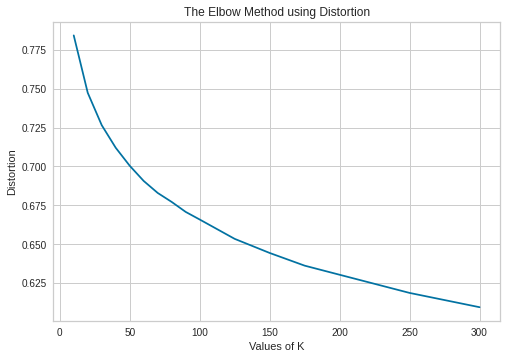

In [ ]:
k = [10, 20, 30, 40, 50, 60, 70 ,80, 90,100,125,150,175,200,250,300]

distortion(embeddings_user, k)

Total WCE: 1708.4607753655444
Total Cluster: 150 
Total count of uttarance in Clusters:15799


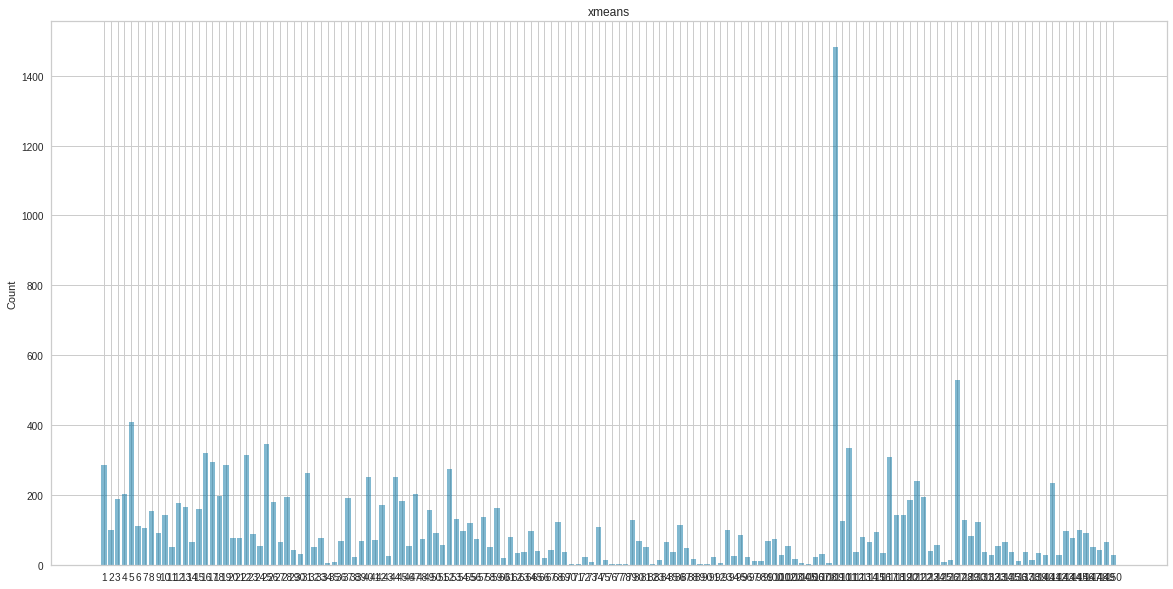

CPU times: user 48.6 s, sys: 404 ms, total: 49 s
Wall time: 49.8 s


In [119]:
%%time
number_of_clusters = 150
clusters_user, centers_user = xmeans_clustering(embeddings_user, number_of_clusters)

In [121]:
items_to_show_per_cluster = 30

print_cluster_items(clusters_user, cleaned_texts_user, items_to_show_per_cluster)



Cluster No: 0	 Count: [287]

51 thank you that s all i needed help with today goodbye
118 just one please
119 yes i need the reference number for the booking please
150 book the one in the centre a table for 2 at 1345 on thursday
264 i d like to leave the hotel by 315 please
378 well what is on the west side then
440 how about asian oriental food
499 ok are there any 4 star hotels with free wifi
608 great can you book that for 7 people for 3 nights starting friday
735 perfect thanks so much for your help today that s everything i needed
795 no thank you
810 three nights and three people from thursday on
811 fantastic i d also like a taxi to take me between the two locations please
853 i need a place to stay
867 awesome thanks i m also looking for a train that leaves on sunday after 1315
887 i m looking for a decently priced guesthouse i can stay at for the day
968 maybe i need to leave cambridge on friday will that train work
1055 i would love indian food preferable in the expensive 

In [122]:
user_clusters_combined = clustering_clusters(centers_user, clusters_user)

user_text_clusters_id = {} #it will be used later

for idx, c in enumerate(user_clusters_combined):
  for i in c:
    user_text_clusters_id[cleaned_texts_user[i]] = f'u-{idx}'

# system utterances only

In [126]:
cleaned_texts_system = list(df_train.loc[df_train['speaker'] == "SYSTEM", 'cleaned_text'])

embeddings_system =  embed(df_train[df_train["speaker"]=="SYSTEM"], df_test[df_test["speaker"]=="SYSTEM"], preprocess,get_embeddings )

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


16662 6540 216449


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


6137 3714 81368


In [ ]:
# test_utterances = test_utterances = choices(cleaned_texts_system, k = 20)

# show_top_5_similar_embeddings(embeddings_system, cleaned_texts_system, test_utterances)

Utterance: what day are you traveling and what is your destination
Top 5: 
0.8512983322143555 what day would you be traveling and where are you going to
0.8513992428779602 on what day do you wish to travel and to what destination
0.8552616834640503 certainly what is your destination and what day will you be leaving
0.8590325713157654 okay where is the destination and what day would you like to travel
0.9511547684669495 what is your destination and what day are you hoping to travel

Utterance: well riverboat georgina is in the north
Top 5: 
0.6727368831634521 the riverboat georgina would work it s in the north do you need more information
0.6759232878684998 the riverboat georgina in a boating place and is in the north
0.7117735743522644 there is the riverboat georgina in the north would you like the information for it
0.7224326729774475 i have a listing for riverboat georgina in the north is that okay
0.765608549118042 riverboat georgina is in the north do you want their information

Ut

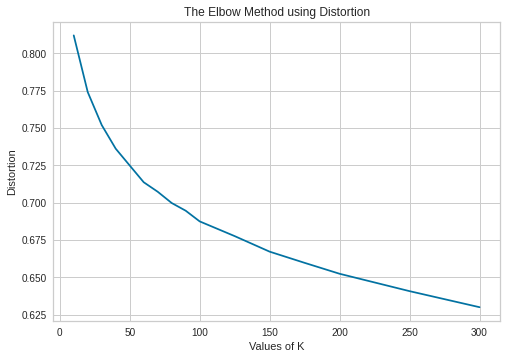

In [ ]:
k = [10, 20, 30, 40, 50, 60, 70 ,80, 90,100,125,150,175,200,250,300]

distortion(embeddings_system, k)

Total WCE: 1849.7979910982276
Total Cluster: 150 
Total count of uttarance in Clusters:15799


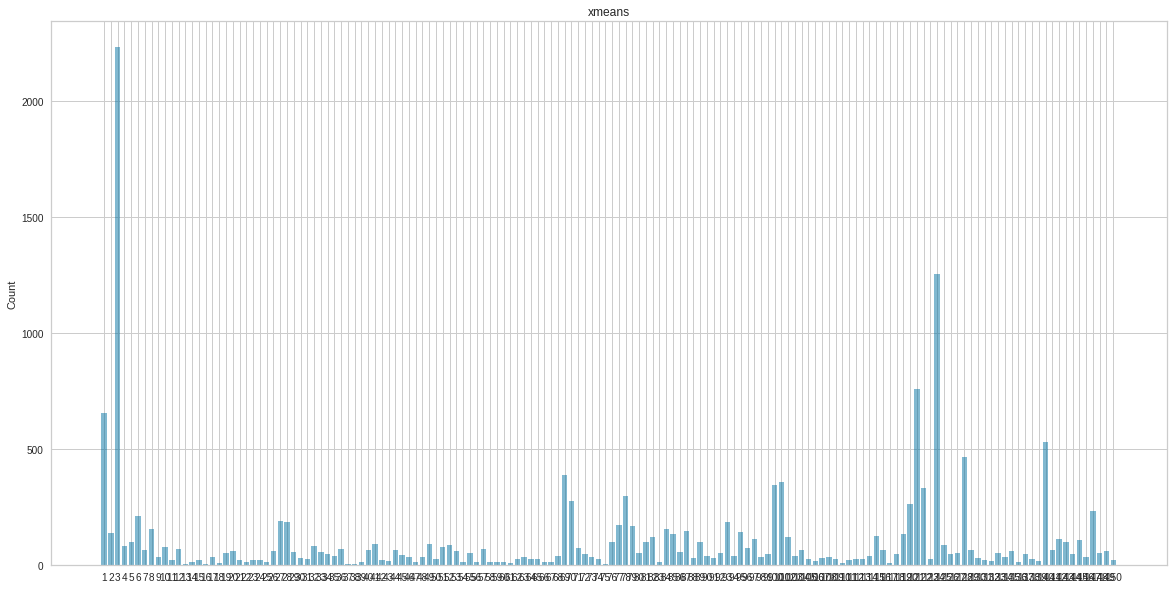

CPU times: user 36.7 s, sys: 344 ms, total: 37.1 s
Wall time: 36.6 s


In [127]:
%%time
number_of_clusters = 150
clusters_system, centers_system = xmeans_clustering(embeddings_system, number_of_clusters)

In [128]:
items_to_show_per_cluster = 30

print_cluster_items(clusters_system, cleaned_texts_system, items_to_show_per_cluster)



Cluster No: 0	 Count: [656]

11 at what time should it leave
46 booking was successful reference number is 9upu6tfe can i help you with anything else today
90 if you take the tr8224 you ll get to bishop s stortford at 1207
177 their phone number is 01223356354 do you need anything else
195 tr5488 will depart norwich at 1816 on tuesday arriving in cambridge at 1935 would you like to book passage
208 i am sorry it appears that the hotel does not have anything available would you like to try a shorter stay or a different check in date
304 the man on the moon is a fantastic concerthall located in the centre at 2 norfolk street postcode cb12lf i do nt have an entrance fee available but you could call 01223474144
393 you re welcome please feel free to let us know if there s anything else we can assist you with
410 yes how many days will you want to stay
438 curry garden is a nice place do you want their info
477 alright i have train tr4813 that leaves sunday at 1432 from broxbourne will th

In [129]:
system_clusters_combined = clustering_clusters(centers_system, clusters_system )


system_text_clusters_id = {}

for idx, c in enumerate(system_clusters_combined):
  for i in c:
    system_text_clusters_id[cleaned_texts_system[i]] = f's-{idx}'



Creating df of Nodes

In [130]:
user_nodes = save_nodes_with_n_utterances("u", 10, user_clusters_combined, cleaned_texts_user)

system_nodes = save_nodes_with_n_utterances("s", 10, system_clusters_combined, cleaned_texts_system)

In [131]:
nodes = {**user_nodes , **system_nodes}


In [132]:
nodes_df = pd.Series(nodes).to_frame('utterenaces')
#nodes_df = pd.DataFrame.from_dict(nodes, orient='index')
#nodes_df = nodes_df.T
nodes_df.to_csv("nodes_USE_with_10_utterances.csv")
nodes_df

,utterenaces
u-0,[thank you that s all i needed help with today...
u-1,[yes i also need to find a train from cambridg...
u-2,[i am traveling to cambridge and looking forwa...
u-3,[yes i also need a taxi from the restaurant to...
u-4,"[yeah that would be great thanks, can i have t..."
...,...
s-67,[i have 10 places matching your request what p...
s-68,"[did you have a preference for the area, thank..."
s-69,[camboats is a great place in the east do you ...
s-70,[the telephone for the paediatric clinic at ad...


# Getting Clusters and Edges

In [133]:
def get_cluste_id(text, speaker):

  if speaker == "USER":
    return user_text_clusters_id[text] if text in user_text_clusters_id else "User No Cluster"   

  elif speaker == "SYSTEM":
    return system_text_clusters_id[text] if text in system_text_clusters_id else "System No Cluster"

In [134]:
df_train["cluster_id"] = df_train.apply(lambda x: get_cluste_id(x['cleaned_text'].strip(),  x['speaker']) , axis=1)

In [135]:
df_train

,Unnamed: 0,dialogue_id,services,services_list,utterance_no,utterance_id,next_utterance_id,speaker,text,cleaned_text,cluster_id
0,0,SNG02022,hospital,['hospital'],0,0-SNG02022,1-SNG02022,USER,I am looking for the Addenbrookes Hospital wit...,i am looking for the addenbrookes hospital wit...,u-74
1,1,SNG02022,hospital,['hospital'],1,1-SNG02022,2-SNG02022,SYSTEM,The telephone number is 01223217712,the telephone number is 01223217712,s-57
2,2,SNG02022,hospital,['hospital'],2,2-SNG02022,3-SNG02022,USER,Thank you Goodbye,thank you goodbye,u-79
3,3,SNG02022,hospital,['hospital'],3,3-SNG02022,,SYSTEM,Have a wonderful day!,have a wonderful day,s-71
4,4,PMUL4452,restaurant & taxi & hotel,"['restaurant', 'taxi', 'hotel']",0,0-PMUL4452,1-PMUL4452,USER,I am traveling to Cambridge and looking forwar...,i am traveling to cambridge and looking forwar...,u-44
...,...,...,...,...,...,...,...,...,...,...,...
33319,33319,MUL2568,taxi & attraction & hotel,"['taxi', 'attraction', 'hotel']",15,15-MUL2568,16-MUL2568,SYSTEM,I have booked a car from the acorn to country ...,i have booked a car from the acorn to country ...,System No Cluster
33320,33320,MUL2568,taxi & attraction & hotel,"['taxi', 'attraction', 'hotel']",16,16-MUL2568,17-MUL2568,USER,No that was it. Thanks for your help!,no that was it thanks for your help,u-57
33321,33321,MUL2568,taxi & attraction & hotel,"['taxi', 'attraction', 'hotel']",17,17-MUL2568,18-MUL2568,SYSTEM,So glad that I could assist. Please call again.,so glad that i could assist please call again,System No Cluster
33322,33322,MUL2568,taxi & attraction & hotel,"['taxi', 'attraction', 'hotel']",18,18-MUL2568,19-MUL2568,USER,Ok. Good bye!,ok good bye,User No Cluster


In [136]:
df_train = df_train.set_index('utterance_id')

In [137]:
df_train

,Unnamed: 0,dialogue_id,services,services_list,utterance_no,next_utterance_id,speaker,text,cleaned_text,cluster_id
utterance_id,,,,,,,,,,
0-SNG02022,0,SNG02022,hospital,['hospital'],0,1-SNG02022,USER,I am looking for the Addenbrookes Hospital wit...,i am looking for the addenbrookes hospital wit...,u-74
1-SNG02022,1,SNG02022,hospital,['hospital'],1,2-SNG02022,SYSTEM,The telephone number is 01223217712,the telephone number is 01223217712,s-57
2-SNG02022,2,SNG02022,hospital,['hospital'],2,3-SNG02022,USER,Thank you Goodbye,thank you goodbye,u-79
3-SNG02022,3,SNG02022,hospital,['hospital'],3,,SYSTEM,Have a wonderful day!,have a wonderful day,s-71
0-PMUL4452,4,PMUL4452,restaurant & taxi & hotel,"['restaurant', 'taxi', 'hotel']",0,1-PMUL4452,USER,I am traveling to Cambridge and looking forwar...,i am traveling to cambridge and looking forwar...,u-44
...,...,...,...,...,...,...,...,...,...,...
15-MUL2568,33319,MUL2568,taxi & attraction & hotel,"['taxi', 'attraction', 'hotel']",15,16-MUL2568,SYSTEM,I have booked a car from the acorn to country ...,i have booked a car from the acorn to country ...,System No Cluster
16-MUL2568,33320,MUL2568,taxi & attraction & hotel,"['taxi', 'attraction', 'hotel']",16,17-MUL2568,USER,No that was it. Thanks for your help!,no that was it thanks for your help,u-57
17-MUL2568,33321,MUL2568,taxi & attraction & hotel,"['taxi', 'attraction', 'hotel']",17,18-MUL2568,SYSTEM,So glad that I could assist. Please call again.,so glad that i could assist please call again,System No Cluster


In [138]:
df_train["next_utterance_cluster_id"] = df_train.apply(lambda x: df_train.loc[x['next_utterance_id']]["cluster_id"] if x['next_utterance_id'] != "" else None,  axis=1)

In [139]:
df_train.to_csv("dialogue_clusters_USE_200_with_replacement.csv")

In [140]:
df_edges = df_train[["cluster_id", "next_utterance_cluster_id"]]
df_edges = df_edges.dropna()
df_edges.columns = ['Source', 'Target']

df_edges

,Source,Target
utterance_id,,
0-SNG02022,u-74,s-57
1-SNG02022,s-57,u-79
2-SNG02022,u-79,s-71
0-PMUL4452,u-44,s-1
1-PMUL4452,s-1,u-18
...,...,...
14-MUL2568,User No Cluster,System No Cluster
15-MUL2568,System No Cluster,u-57
16-MUL2568,u-57,System No Cluster


In [141]:
df_edges.to_csv("edges_USE_200_with_replacement.csv")

In [142]:
df_edges_weights = df_edges.groupby(['Source','Target']).size().reset_index().rename(columns={0:'Weight'})
df_edges_weights


,Source,Target,Weight
0,System No Cluster,User No Cluster,588
1,System No Cluster,u-0,1
2,System No Cluster,u-1,2
3,System No Cluster,u-13,1
4,System No Cluster,u-14,1
...,...,...,...
7111,u-9,s-69,1
7112,u-9,s-7,1
7113,u-9,s-71,2
7114,u-9,s-8,1


In [143]:
df_edges_weights.to_csv("edges_weight_USE_200_with_replacement.csv")